In [1]:
!pip install shap --quiet
!pip install xgboost --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import KNNImputer,IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix , accuracy_score , precision_score , recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from model_utils import *
from scipy.stats import chi2
import shap
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings("ignore")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
data = pd.read_excel("Data for Case Study.xlsx")
df = data.copy()

# Function to handle mixed date formats
def convert_mixed_dates(date):
    if isinstance(date, (int, float)):  # If it's a number, convert from Excel serial date
        return pd.to_datetime('1899-12-30') + pd.to_timedelta(date, unit='D')
    else:  # If it's already a timestamp, convert to datetime
        return pd.to_datetime(date, errors='coerce')

# Apply the function to the column
df['Date Replied'] = df['Date Replied'].apply(convert_mixed_dates)
df.columns = df.columns.str.replace('"', '').str.replace(" - ", "_").str.replace(" ", "_").str.replace('__', '_').str.replace('_MYSITE', 'MYSITE').str.lower()
print(df.shape)
df.head()

(8460, 66)


,control_count,date_replied,status,unique_identifier,likely_to_recommend_online_site_my_site,purchased_from_site_a,purchased_from_site_b,purchased_from_site_c,purchased_from_site_d,purchased_from_site_e,purchased_from_site_f,purchased_from_site_g,purchased_from_site_h,purchased_from_site_i,purchased_from_site_j,purchased_from_site_k,purchased_from_site_l,purchased_from_site_m,purchased_from_site_n,purchased_from_site_o,purchased_from_site_p,purchased_from_site_q,purchased_from_site_r,purchased_from_site_s,purchased_from_site_t,purchased_from_site_u,purchased_from_site_v,purchased_from_site_w,purchased_from_site_x,purchased_from_site_y,purchased_from_my_site_only,#_of_online_sites_used,mysite_rank,sales_reps_responsiveness,sales_reps_ease_of_making_contact,sales_reps_general_attitude,sales_reps_quotation,sales_reps_relationship,sales_reps_overall_satisfaction,customer_service_responsiveness,customer_service_ease_of_making_contact,customer_service_general_attitude,customer_service_knowledge_of_business,customer_service_issue_resolution,customer_service_keeping_customers_informed,customer_service_overall_satisfaction,delivery_on_time_schedules,delivery_on_time_coverage,delivery_on_time_keeping_customers_informed,delivery_on_time_accuracy_transit_time,delivery_on_time_availability_of_products,delivery_on_time_speed,delivery_on_time_overall_satisfaction,ease_of_business_booking,ease_of_business_documentation,ease_of_business_invoicing,ease_of_business_online_system,ease_of_business_overall_satisfaction,improving_business_opps_knowledge_of_business,improving_business_opps_understanding_of_needs,improving_business_opps_demonstrating_opps,improving_business_opps_specific_offers,improving_business_opps_overall_satisfaction,overall_satisfaction_taking_everything_into_account,proportion_of_purchase_made_with_my_site,future_proportion_of_purchase_made_at_my_site
0,Day 1,2016-08-19,COMPLETED,711315000105288,10,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2.0,8.0,8.0,10.0,10.0,10.0,10.0,10.0,9.0,5.0,5.0,4.0,99.0,9.0,9.0,10.0,8.0,10.0,10.0,10.0,10.0,5.0,2.0,2.0,8.0,8.0,8.0,7.0,8.0,7.0,6.0,8.0,76% to 99%,Increase
1,Day 1,2016-08-19,COMPLETED,391315000163276,7,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2.0,9.0,9.0,8.0,8.0,9.0,9.0,9.0,9.0,9.0,9.0,10.0,9.0,8.0,8.0,8.0,9.0,8.0,9.0,8.0,8.0,8.0,9.0,8.0,8.0,8.0,8.0,10.0,9.0,7.0,8.0,9.0,26% to 50%,Increase
2,Day 1,2016-08-19,COMPLETED,501315000258371,6,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,16.0,7.0,99.0,99.0,99.0,99.0,99.0,99.0,1.0,8.0,7.0,7.0,5.0,1.0,6.0,7.0,8.0,1.0,8.0,8.0,6.0,6.0,7.0,4.0,1.0,8.0,6.0,99.0,99.0,99.0,99.0,99.0,6.0,Don’t know,Don’t know
3,Day 1,2016-08-19,COMPLETED,1001315000329142,7,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,13.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6% to 15%,Stay the same
4,Day 1,2016-08-19,COMPLETED,101315000387196,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,1.0,10.0,10.0,10.0,10.0,10.0,10.0,4.0,10.0,5.0,4.0,10.0,9.0,6.0,9.0,10.0,9.0,8.0,10.0,9.0,9.0,1.0,7.0,1.0,1.0,2.0,10.0,10.0,10.0,10.0,9.0,9.0,51% to 75%,Increase


In [4]:
## Ratings Columns
sales_reps = df.filter(regex='^sales_reps').columns.tolist()
customer_service = df.filter(regex='^customer_service').columns.tolist()
delivery_on_time = df.filter(regex='^delivery_on_time').columns.tolist()
ease_of_business = df.filter(regex='^ease_of_business').columns.tolist()
improving_business_opps = df.filter(regex='^improving_business_opps').columns.tolist()
product_purchased_col = df.filter(regex='^purchased_from').columns.tolist()

In [5]:
#### In a rating based column i.e 0 - 10 rating, a 99 value may indicate a system generated error or missing value coded as 99
rating_columns = sales_reps + customer_service + delivery_on_time + ease_of_business + improving_business_opps + product_purchased_col + ['overall_satisfaction_taking_everything_into_account']
for i in rating_columns:
    df[i] = np.where(df[i] == 99, np.nan, df[i])
df = df[~(df[rating_columns + product_purchased_col].isnull().all(axis = 1))].reset_index(drop = True)### Removing rows were all the entires are missing, and won't be useful for this analysis
print("DataFrame Shape:",df.shape)
print(f"Dropped {data.shape[0] - df.shape[0]} rows where all the ratings and product purchased data was missing")

DataFrame Shape: (7366, 66)
Dropped 1094 rows where all the ratings and product purchased data was missing


### Missing Value Imputation

In [6]:
df1 = df.copy()
df1[product_purchased_col] = df1[product_purchased_col].fillna(0)  ### Since these are indicator columns, whether product was purchased from a Site or not, SO the missing values should be filled with zero
df1['#_of_online_sites_used_v1'] = df1[product_purchased_col].sum(axis = 1)
df1['mysite_rank'] = np.where(((df1['purchased_from_my_site_only'] == 1) & (df1['#_of_online_sites_used_v1'] == 1) & (df1['mysite_rank'].isna())),1,df1['mysite_rank'])  ## Where mysite rank is null and no. of online site used is 1, fillna with 1

In [7]:
conditions = [(df1['proportion_of_purchase_made_with_my_site'].isin(['Prefer not to say','Don’t know'])),
                 (df1['proportion_of_purchase_made_with_my_site'] == '1% to 5%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '6% to 15%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '16% to 25%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '26% to 50%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '51% to 75%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '76% to 99%'),
                 (df1['proportion_of_purchase_made_with_my_site'].isna())]

values = [0,1,2,3,4,5,6,np.nan]
df1['proportion_of_purchase_made_with_my_site_numeric'] = np.select(conditions ,values)

In [8]:
### MICE Imputation
df4 = df1.copy()
rating_columns =sales_reps + customer_service + delivery_on_time + ease_of_business + improving_business_opps + ['overall_satisfaction_taking_everything_into_account','proportion_of_purchase_made_with_my_site_numeric','mysite_rank']
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
df4[rating_columns] = mice_imputer.fit_transform(df4[rating_columns])
df4[rating_columns] = round(df4[rating_columns],0)
df4['proportion_of_purchase_made_with_my_site_numeric'] = np.where(df4['proportion_of_purchase_made_with_my_site_numeric'] == -1,1,df4['proportion_of_purchase_made_with_my_site_numeric'])

### Target Definition

In [9]:
def categorize_nps(score):
    if score >= 7:
        return 1  # Promoters (9-10) & Passives (7-8)
    else:
        return 0  # Detractors

df4["LTR_Category"] = df4["likely_to_recommend_online_site_my_site"].apply(categorize_nps)

In [10]:
df4["LTR_Category"].value_counts(normalize = True)*100

1    55.41678
0    44.58322
Name: LTR_Category, dtype: float64

## Feature Scaling and Train Test Split

In [11]:
X = df4[sales_reps[:-1] + customer_service[:-1] + delivery_on_time[:-1] + ease_of_business[:-1] + improving_business_opps[:-1] + ['proportion_of_purchase_made_with_my_site_numeric','mysite_rank']]
y = df4[["LTR_Category"]]
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Small spikes suggest potential non-linearity in the relationshipships

### Random Forest

In [12]:
# ##  Fine-tuning in the neighbourhood 

# max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
# n_estimators=[int(x) for x in np.linspace(start = 50, stop = 200, num = 15)]
# max_features=['sqrt','log2']
# bootstrap=[True,False]

# param_grid = {'n_estimators':n_estimators,'max_depth': max_depth,
#     'min_samples_leaf': min_samples_leaf,'max_features':max_features,'bootstrap':bootstrap}
# print(param_grid)

# # Create a xgboost classifier
# rf_model = RandomForestClassifier(random_state=42)

# # Use random search to find the best hyperparameters
# tree_random = RandomizedSearchCV(estimator = rf_model,param_distributions = param_grid,n_iter = 100,cv = 5,verbose = 1,random_state = 4,n_jobs = -1,scoring='f1')
# tree_random.fit(X_train, y_train)
# # Print the best hyperparameters
# tree_random.best_params_

Results on Trainng Data :
Confusion Matrix:



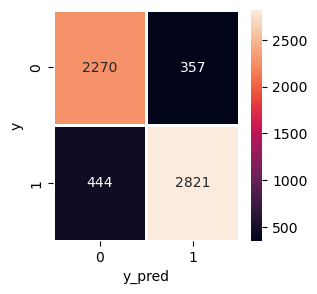

ROC Curve:



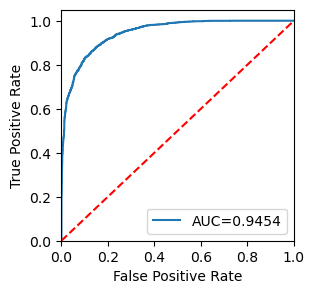

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2627
           1       0.89      0.86      0.88      3265

    accuracy                           0.86      5892
   macro avg       0.86      0.86      0.86      5892
weighted avg       0.86      0.86      0.86      5892

Precision Score for Positive Class : 0.8877
Recall Score for Positive Class: 0.864
f1 Score for Positive Class: 0.8757
Accuracy Score for Positive Class: 0.8641
Results on Validation Data :
Confusion Matrix:



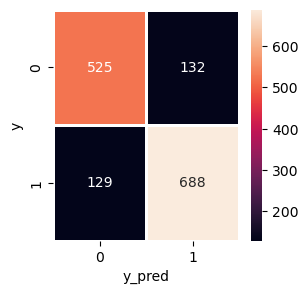

ROC Curve:



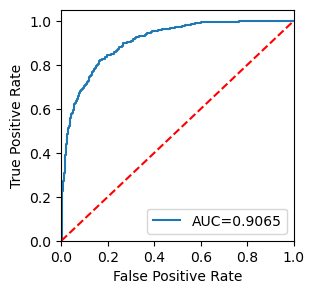

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       657
           1       0.84      0.84      0.84       817

    accuracy                           0.82      1474
   macro avg       0.82      0.82      0.82      1474
weighted avg       0.82      0.82      0.82      1474

Precision Score for Positive Class : 0.839
Recall Score for Positive Class: 0.8421
f1 Score for Positive Class: 0.8406
Accuracy Score for Positive Class: 0.8229


In [13]:
# Initialize and Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=4,min_samples_leaf = 10, max_features = 'sqrt', max_depth = 15, bootstrap = True)
rf_model.fit(X_train, y_train)

cutoff = 0.55
y_pred_proba_train = rf_model.predict_proba(X_train)[:,1]
y_pred_train = np.where(y_pred_proba_train> cutoff,1,0)

print ('Results on Trainng Data :')
model_evaluation_report(y_train,y_pred_train,y_pred_proba_train)

y_pred_proba_test = rf_model.predict_proba(X_test)[:,1]
y_pred_test = np.where(y_pred_proba_test> cutoff,1,0)

print ('Results on Validation Data :')
model_evaluation_report(y_test,y_pred_test,y_pred_proba_test)

In [14]:
## First run of decision tree feature importance
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.width = 500

## Feature Importance from the model
imp_data=pd.DataFrame({'features': X_train.columns,'Imp':rf_model.feature_importances_})
imp_data['Imp']=round(imp_data['Imp'],6)*100
imp_data.sort_values('Imp',ascending=False,inplace=True)
imp_data.reset_index(inplace=True,drop=True)
display(imp_data)

,features,Imp
0,customer_service_issue_resolution,13.2062
1,customer_service_responsiveness,11.4206
2,improving_business_opps_specific_offers,9.4190
3,ease_of_business_documentation,7.8048
4,customer_service_general_attitude,7.2368
5,ease_of_business_booking,5.6293
6,improving_business_opps_demonstrating_opps,5.5717
7,customer_service_knowledge_of_business,4.6268
8,ease_of_business_invoicing,3.4880
9,mysite_rank,3.3610


## XGB

In [15]:
# ##  Fine-tuning in the neighbourhood 

# max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# min_sample_leaf_nodes = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# est=[int(x) for x in np.linspace(start = 50, stop = 200, num = 15)]
# min_child_weight=[int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
# colsample_bytree=[float(x) for x in np.linspace(start = 0.1, stop = 0.9, num = 9)]
# subsample=[float(x) for x in np.linspace(start = 0.1, stop = 0.9, num = 9)]
# gamma=[float(x) for x in np.linspace(start = 0.1, stop = 0.9, num = 9)]
# learning_rate=[float(x) for x in np.linspace(start = 0.01, stop = 0.09, num = 9)]




# param_grid = {'n_estimators':est,'max_depth': max_depth,
#     'max_leaves': min_sample_leaf_nodes,'min_child_weight':min_child_weight,'colsample_bytree':colsample_bytree,'subsample':subsample,'gamma':gamma,'learning_rate':learning_rate, 'objective' :['binary:logistic'],'importance_type' : ['gain']}
# print(param_grid)

# # Create a xgboost classifier
# xgb3 = XGBClassifier(random_state=4)

# # Use random search to find the best hyperparameters
# tree_random = RandomizedSearchCV(estimator = xgb3,param_distributions = param_grid,n_iter = 100,cv = 10,verbose = 1,random_state = 4,n_jobs = -1,scoring='accuracy')
# tree_random.fit(X_train, y_train)
# # Print the best hyperparameters
# print(tree_random.best_params_)
# print("Best Cross-Validation Score:", tree_random.best_score_)

Results on Trainng Data :
Confusion Matrix:



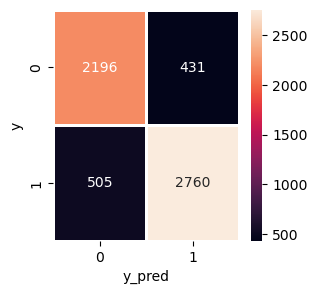

ROC Curve:



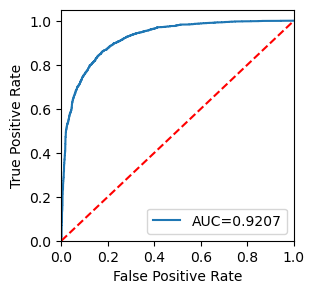

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      2627
           1       0.86      0.85      0.86      3265

    accuracy                           0.84      5892
   macro avg       0.84      0.84      0.84      5892
weighted avg       0.84      0.84      0.84      5892

Precision Score for Positive Class : 0.8649
Recall Score for Positive Class: 0.8453
f1 Score for Positive Class: 0.855
Accuracy Score for Positive Class: 0.8411
Results on Validation Data :
Confusion Matrix:



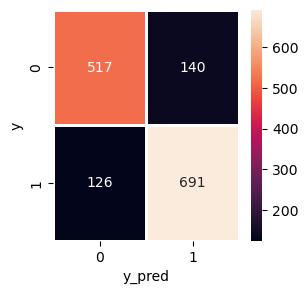

ROC Curve:



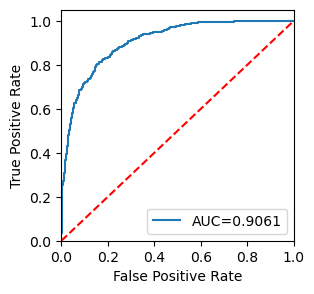

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       657
           1       0.83      0.85      0.84       817

    accuracy                           0.82      1474
   macro avg       0.82      0.82      0.82      1474
weighted avg       0.82      0.82      0.82      1474

Precision Score for Positive Class : 0.8315
Recall Score for Positive Class: 0.8458
f1 Score for Positive Class: 0.8386
Accuracy Score for Positive Class: 0.8195


In [16]:
# Train an XGBoost model
xgb_model = XGBClassifier(random_state=4,subsample= 0.3,n_estimators= 100,min_child_weight= 6,
                         max_leaves= 14,max_depth= 10,learning_rate= 0.04,gamma= 0.5,colsample_bytree= 0.4,objective='binary:logistic')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

cutoff = 0.55
y_pred_proba_train = xgb_model.predict_proba(X_train)[:,1]
y_pred_train = np.where(y_pred_proba_train> cutoff,1,0)

print ('Results on Trainng Data :')
model_evaluation_report(y_train,y_pred_train,y_pred_proba_train)

y_pred_proba_test = xgb_model.predict_proba(X_test)[:,1]
y_pred_test = np.where(y_pred_proba_test> cutoff,1,0)

print ('Results on Validation Data :')
model_evaluation_report(y_test,y_pred_test,y_pred_proba_test)

In [17]:
## First run of decision tree feature importance
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.width = 500

## Feature Importance from the model
imp_data=pd.DataFrame({'features': X_train.columns,'Imp':xgb_model.feature_importances_})
imp_data['Imp']=round(imp_data['Imp'],6)*100
imp_data.sort_values('Imp',ascending=False,inplace=True)
imp_data.reset_index(inplace=True,drop=True)
display(imp_data)

,features,Imp
0,customer_service_issue_resolution,17.860701
1,improving_business_opps_specific_offers,9.046800
2,sales_reps_ease_of_making_contact,6.284300
3,customer_service_ease_of_making_contact,5.535500
4,ease_of_business_documentation,5.454300
5,improving_business_opps_understanding_of_needs,4.821300
6,ease_of_business_booking,4.813900
7,customer_service_responsiveness,4.135300
8,ease_of_business_online_system,3.613500
9,mysite_rank,3.366800


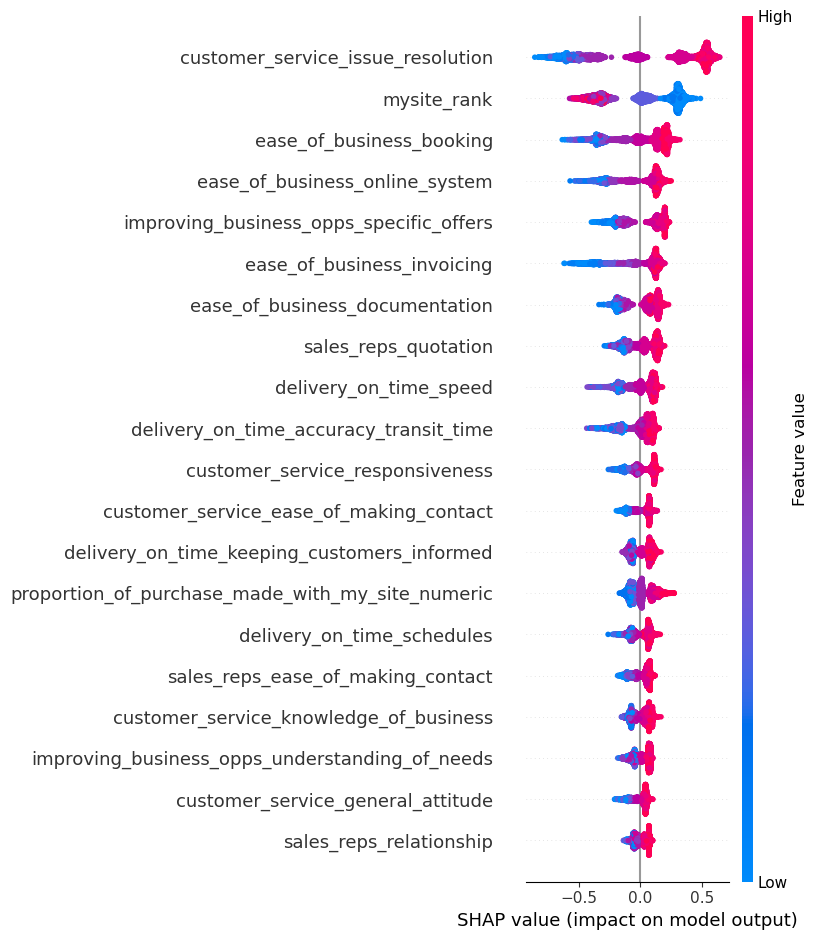

In [18]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [19]:
summary =  {'Evaluation_metrics':['Training_accuracy', 'Testing_accuracy', 'Precision','Specificity','Recall(Sensitivity)','f1-Score'],
        'Random Forest':[accuracy_score(y_train,rf_model.predict(X_train)),accuracy_score(y_test,rf_model.predict(X_test)), precision_score(y_test,rf_model.predict(X_test)),recall_score(y_test,rf_model.predict(X_test),pos_label=0),recall_score(y_test,rf_model.predict(X_test)),f1_score(y_test,rf_model.predict(X_test))],
        'Xgb':[accuracy_score(y_train,xgb_model.predict(X_train)),accuracy_score(y_test,xgb_model.predict(X_test)), precision_score(y_test,xgb_model.predict(X_test)),recall_score(y_test,xgb_model.predict(X_test),pos_label=0) ,recall_score(y_test,xgb_model.predict(X_test)),f1_score(y_test,xgb_model.predict(X_test))]}

In [20]:
pd.DataFrame(summary).set_index('Evaluation_metrics')

,Random Forest,Xgb
Evaluation_metrics,,
Training_accuracy,0.865411,0.841310
Testing_accuracy,0.818182,0.822252
Precision,0.816609,0.821553
Specificity,0.757991,0.765601
Recall(Sensitivity),0.866585,0.867809
f1-Score,0.840855,0.844048
